## Homework 4 CME306
### Problem 5.18

We will solve the boundary value problem $-\Delta u = f$ on $\Omega=(0,1)^2$ with $u=0$ on $\partial\Omega$ using the finite element method based on piecewise linear approximating functions, using a specific triangulation method and quadrature method described in the handwritten notes. $f$ is defined by $f(x) = \sin(\pi x_1)\sin(\pi x_2) + \sin(\pi x_1)\sin(2\pi x_2)$ for $x \in \Omega$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    """
    Given a M * 2 matrix of M points in Omega, compute the value of the function f on each of these points
    """
    x1, x2 = x[:, 0], x[:, 1]
    return np.sin(np.pi * x1) * np.sin(np.pi * x2) + np.sin(np.pi * x1) * np.sin(2 * np.pi * x2)

In [3]:
def exact_solution(x):
    """
    Given a M * 2 matrix of M points in Omega, compute the value of the exact solution on each of these points
    """
    x1, x2 = x[:, 0], x[:, 1]
    return (2 * np.pi ** 2) ** (-1) * np.sin(np.pi * x1) * np.sin(np.pi * x2) + (5 * np.pi ** 2) ** (-1) * np.sin(np.pi * x1) * np.sin(2 * np.pi * x2)

In [4]:
def compute_barycenters(M):
    """
    Returns a list of the 2 * M ^ 2 barycentres of the triangles used for the triangulation of Omega
    """
    barycenters = np.zeros((2 * M ** 2, 2))
    h = 1 / M
    # For each square, the top left triangle has barycenter h * (1 / 3, 2 / 3) where origin is the bottom left vertex
    # The bottom right triangle has barycenter h * (2 / 3, 1 / 3) where origin is the bottom left vertex
    index = 0
    for j in range (M):
        for i in range(M):
            # Considering the square with bottom left vertex (i * h, j * h)
            barycenters[index, :] = h * (i + 1 / 3), h * (j + 2 / 3)
            barycenters[index + 1, :] = h * (i + 2 / 3), h * (j + 1 / 3)
            index += 2
    
    return barycenters

In [5]:
def integral(phi, M):
    """
    Given a function phi defined by its values on the barycenters, computes its approximate integral on Omega using the quadratic barycentre rule
    """
    h = 1 / M
    
    # h ^ 2 / 2 is the area of one triangle
    approximation = 0.5 * h ** 2 * phi.sum()
    
    return approximation

In [6]:
def phi(M):
    """
    Defining the matrix corresponding to function phi_{i, j} values for each of the 2 * M ^ 2 barycenters
    The center is the point P with coordinates (h * i, h * j) and 1 <= i, j <= M - 1
    Only defining Phi by its values on the barycenters. By linearity, 0 on every triangle and 1 / 3 on the 6 triangles
    around P
    """
    
    values_phi = np.zeros((2 * M ** 2, (M - 1) ** 2))
    
    column = 0
    for j in range(1, M):
        for i in range(1, M):
            # Considering the interior mesh point (i * h, j * h)
            # Solving these cases graphically
            values_phi[2 * M * j + 2 * i, column] = 1 / 3
            values_phi[2 * M * j + 2 * i + 1, column] = 1 / 3
            values_phi[2 * M * (j - 1) + 2 * (i - 1), column] = 1 / 3
            values_phi[2 * M * (j - 1) + 2 * (i - 1) + 1, column] = 1 / 3
            values_phi[2 * M * j + 2 * (i - 1) + 1, column] = 1 / 3
            values_phi[2 * M * (j - 1) + 2 * i, column] = 1 / 3
            
            # Incrementing column
            column += 1
    
    return values_phi

In [7]:
def grad_phi(M):
    """
    Defining the matrix corresponding to function grad_phi_{i, j} values for each of the 2 * M ^ 2 barycenters
    The center is the point P with coordinates (h * i, h * j) and 1 <= i, j <= M - 1
    Only defining Grad_Phi by its values on the barycenters
    """
    
    h = 1 / M
    
    values_grad_phi = np.zeros((2 * M ** 2, (M - 1) ** 2, 2))
    
    column = 0
    for j in range(1, M):
        for i in range(1, M):
            # Considering the interior mesh point (i * h, j * h)
            # Solving these cases graphically
            values_grad_phi[2 * M * j + 2 * i, column, :] = 0, -1 / h
            values_grad_phi[2 * M * j + 2 * i + 1, column, :] = -1 / h, 0
            values_grad_phi[2 * M * (j - 1) + 2 * (i - 1), column, :] = 1 / h, 0
            values_grad_phi[2 * M * (j - 1) + 2 * (i - 1) + 1, column, :] = 0, 1 / h
            values_grad_phi[2 * M * j + 2 * (i - 1) + 1, column, :] = 1 / h, -1 / h
            values_grad_phi[2 * M * (j - 1) + 2 * i, column, :] = -1 / h, 1 / h
            
            # Incrementing column
            column += 1
            
    return values_grad_phi 

In [8]:
def stiffness_matrix(M):
    """
    Creates the (M - 1) ^ 2 * (M - 1) ^ 2 stiffness matrix
    """
    # Defining the matrix
    A = np.zeros(((M - 1) ** 2, (M - 1) ** 2))
    
    # Retrieving gradient values
    values_grad_phi = grad_phi(M)
    
    # Computing coefficients
    for j in range(1, M):
        for i in range(1, M):
            row = (j - 1) * (M - 1) + (i - 1)
            for j1 in range(1, M):
                for i1 in range(1, M):
                    column = (j1 - 1) * (M - 1) + (i1 - 1)
                    fun = (values_grad_phi[:, row, :] * values_grad_phi[:, column, :]).sum(axis=1) # inner product
                    A[row, column] = integral(fun, M)
    
    return A

In [9]:
stiffness_matrix(4)

array([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
       [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
       [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

The stiffness matrix has the expected shape as derived in class! We could have used this shape but the problem asked us to use quadratic approximation methods even for computing this stiffness matrix...

In [10]:
def load_vector(values_phi, barycenters, M):
    """
    Computes the load vector associated with this problem
    """
    
    # Computing the vector of f values
    values_f = f(barycenters)
    
    # Defining the load vector
    b = np.zeros((M - 1) ** 2)
    
    # Computing coefficients
    row = 0
    for j in range(1, M):
        for i in range(1, M):
            fun = values_f * values_phi[:, row]
            b[row] = integral(fun, M)
            row += 1
            
    return b

In [11]:
def plot_stiffness_matrix(A):
    """
    Plots the stiffness matrix A
    """
    plt.imshow(A, cmap='viridis', vmin=np.min(A), vmax=np.max(A))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$i$')
    plt.ylabel(r'$j$')
    plt.title('Color plot of stiffness matrix')
    plt.colorbar()
    plt.show()

In [15]:
def plot_load_vector(b):
    """
    Plots the load vector
    """
    plt.plot(b)
    plt.title('Line plot of the load vector')
    plt.show()

In [16]:
def solve_finite_difference(values_phi, barycenters, M):
    """
    Computes the coefficients in front of each Phi_{i, j} in the approximate solution
    """
    A = stiffness_matrix(M)
    plot_stiffness_matrix(A)
    b = load_vector(values_phi, barycenters, M)
    plot_load_vector(b)
    coefs = np.linalg.inv(A) @ b
    return coefs

In [17]:
def l2_error_solution(coefs, values_phi, barycenters, M):
    """
    Based on coefs output by coefficients_solution, computes the L2 error with the exact solution, still with the same quadrature method
    """
    
    # Computing the vector of exact values
    values_exact = exact_solution(barycenters)
            
    # Linear combination of columns
    values_solution = values_phi @ coefs
    
    # Computing L2 error
    fun = (values_exact - values_solution) ** 2
    error = integral(fun, M) ** 0.5
    
    return error

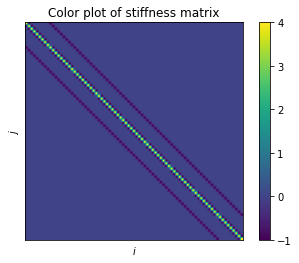

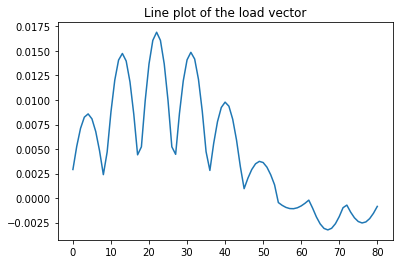

Error for h = 1 / 10: 0.001271676868856643


In [18]:
# h = 1 / 10
M = 10
barycenters10 = compute_barycenters(M)
values_phi10 = phi(M)
coefs10 = solve_finite_difference(values_phi10, barycenters10, M)
error10 = l2_error_solution(coefs10, values_phi10, barycenters10, M)
print(f'Error for h = 1 / {M}: {error10}')

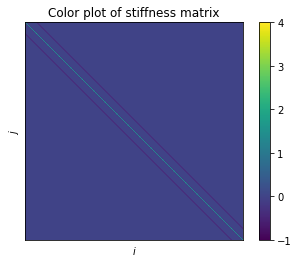

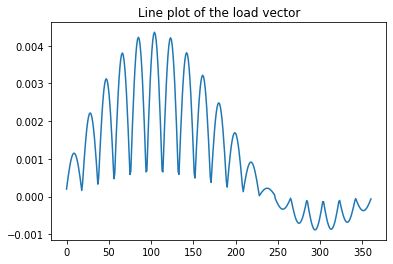

Error for h = 1 / 20: 0.00032364344652091847


In [19]:
# h = 1 / 20
M = 20
barycenters20 = compute_barycenters(M)
values_phi20 = phi(M)
coefs20 = solve_finite_difference(values_phi20, barycenters20, M)
error20 = l2_error_solution(coefs20, values_phi20, barycenters20, M)
print(f'Error for h = 1 / {M}: {error20}')

Dividing $h$ by 2 leads to a reduction of tle $\text{L}^2$ error by a factor 4, with is consistent with the theoretical estimation (the $\text{L}^2$ error is of order $h^2$, and the $\text{H}^1$ error of order $h$).

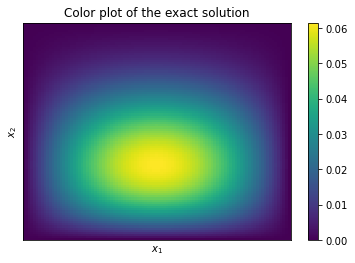

In [26]:
# Color plot of the exact solution
M = 100
h = 1 / M
mesh = np.array([[i * h, j * h] for j in range(M + 1) for i in range(M + 1)])
exact_U = exact_solution(mesh).reshape((M + 1, M + 1))
plt.pcolormesh(exact_U, cmap='viridis', vmin=np.min(exact_U), vmax=np.max(exact_U))
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Color plot of the exact solution')
plt.colorbar()
plt.show()

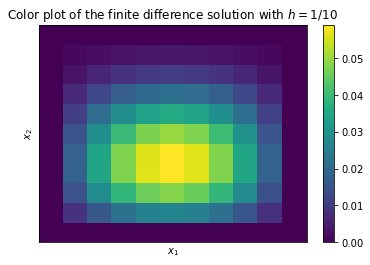

In [28]:
# Color plot for h = 1 / 10
M = 10
U10 = np.zeros((M + 1, M + 1))
U10[1:-1, 1:-1] = coefs10.reshape((M - 1, M - 1))
plt.pcolormesh(U10, cmap='viridis', vmin=np.min(U10), vmax=np.max(U10))
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Color plot of the finite difference solution with $h=1/10$')
plt.colorbar()
plt.show()

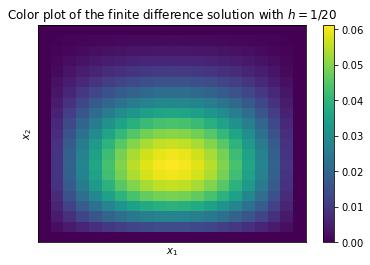

In [29]:
# Color plot for h = 1 / 20
M = 20
U20 = np.zeros((M + 1, M + 1))
U20[1:-1, 1:-1] = coefs20.reshape((M - 1, M - 1))
plt.pcolormesh(U20, cmap='viridis', vmin=np.min(U20), vmax=np.max(U20))
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title(r'Color plot of the finite difference solution with $h=1/20$')
plt.colorbar()
plt.show()